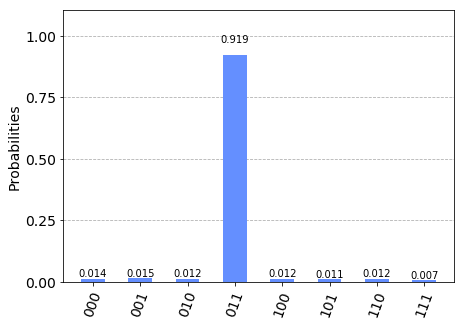

In [3]:
# (C) Copyright Renata Wong 2020.

# This is a simplified validation code for amino acid sequences of length 2 in 
# three dimensions

# Subroutine 1: generates the conformational space by calculating the coordinates 
#              of each conformation
# Subroutine 2: calculates the energy value for each conformation and stores it 
#              in qubit e. Only 1 conformation (w=110 in this case) has e = 1.  
# Subroutine 3: uncomputing coordinate values for all conformations
# Subroutine 4: Grover's algorithm executed three times on vectors w and e
#              the solution 110 obtained with the probability ca. 91%
# Measurement: measure the vector |w> which encodes all directional transitions 
#              for a given conformation

# Number of qubits: 20
# Number of gates: 660 (not transpiled)


from qiskit import *

# The following code is for sequences of length 2 bit only due to limited space

length = 2

# two's complements: 
# 0 = 000, 1 = 001, 2 = 010, 3 = 011, -1 = 111, -2 = 110, -3 = 101 
# (-4 = 100, not needed) 
# For the purpose of this simplified validation we don't need the fixed 
# coordinates of the first amino acid which are all 0

# quantum register holding the x coordinates for x1, x2 etc. (x0 = 000 omitted) 
x = QuantumRegister(3, 'x')
# quantum register holding the y coordinates for y1, y2 etc. (y0 = 000 omitted) 
y = QuantumRegister(3, 'y')
# quantum register holding the y coordinates for z1, z2 etc. (z0 = 000 omitted) 
z = QuantumRegister(3, 'z')

# quantum register holding the controls w0, w1, etc. 
w = QuantumRegister(3, 'w')

# register holding the binary 1 (3 qubits)
a = QuantumRegister(3,'a')

# register holding the two's complement of 1 (3 qubits) not needed, 
# can be replaced by a with the first 2 qubits negated.

# register holding the carry bit for ripple-carry adder
c = QuantumRegister(1,'c')

# quantum register that holds the energy value for each conformation: if first and 
# last amino acid are located diagonally # from each other, e = 1, otherwise e = 0. 
# There are 4 conformations for which e = 1.
e = QuantumRegister(1, 'e')

# classical register
out = ClassicalRegister(3,'out')
# quantum circuit consisting of all quantum and classical registers
qc = QuantumCircuit(x,y,z,w,a,c,e,out) 

# encoding binary 1
qc.x(a[2])
# encoding the two's complement of 1
#qc.x(t[0:length])

# setting the state into superposition
qc.h(w[0:3])

# setting energy qubit e into superposition on par with |w>
qc.h(e[0])


# ancilla qubits, at most three needed for the ccrca function
anc = QuantumRegister(3,'anc') 
qc.add_register(anc)







# subcircuit defined for the controlled-controlled ripple-carry adder for 3 bits
# (the sum is stored by overwriting the values of x)
sw = QuantumRegister(1,'sw')     # control qubits
sa = QuantumRegister(3,'sa')     # ancilla qubits
ss = QuantumRegister(1,'ss')     # carry 
sx = QuantumRegister(3,'sx')   # summand x 
sy = QuantumRegister(3,'sy')   # summand y
sc = QuantumCircuit(sw,sa,ss,sx,sy,name='ccrca')


sc.cx(sw[0],sa[0])

sc.ccx(sa[0],sy[2],sx[2])
sc.ccx(sa[0],sy[2],ss[0])
sc.ccx(sa[0],ss[0],sa[1])
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[1],sa[2],sy[2])
# uncompute
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[0],ss[0],sa[1])

sc.ccx(sa[0],sy[1],sx[1])
sc.ccx(sa[0],sy[1],sy[2])
sc.ccx(sa[0],sy[2],sa[1])
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[1],sa[2],sy[1])
# uncompute
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[0],sy[2],sa[1])

sc.ccx(sa[0],sy[0],sx[0])
sc.ccx(sa[0],sy[0],sy[1])
sc.ccx(sa[0],sy[1],sa[1])
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[1],sa[2],sy[0])
# uncompute
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[0],sy[1],sa[1])

sc.ccx(sa[0],sy[1],sa[1])
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[1],sa[2],sy[0])
# uncompute
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[0],sy[1],sa[1])
# continue
sc.ccx(sa[0],sy[0],sy[1])
sc.ccx(sa[0],sy[1],sx[0])

sc.ccx(sa[0],sy[2],sa[1])
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[1],sa[2],sy[1])
# uncompute
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[0],sy[2],sa[1])
# continue
sc.ccx(sa[0],sy[1],sy[2])
sc.ccx(sa[0],sy[2],sx[1])

sc.ccx(sa[0],ss[0],sa[1])
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[1],sa[2],sy[2])
# uncompute
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[0],ss[0],sa[1])
# continue
sc.ccx(sa[0],sy[2],ss[0])
sc.ccx(sa[0],ss[0],sx[2])

sc.cx(sw[0],sa[0])


subinst = sc.to_instruction()




# global variable used in Subroutine 1 to navigate among the values of vector w
b = 0
arglist = []


# Subroutine 1: Generating conformational space

for d in range (2,length+1):
       
    
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    # if w[0]=1 then x+1, if w[0]=0 then x-1
    arglist.append(w[b])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    #range [0,1,2] for d=2, range [3,4,5] for d=3
    for i in range(0,3): 
        arglist.append(x[i])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst,arglist)
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b])
    arglist.append(w[b])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range(0,3): 
        arglist.append(x[i])
    qc.x(a[0])
    qc.x(a[1])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst,arglist)
    qc.x(a[0])
    qc.x(a[1])
    qc.x(w[b])
    
    
    # if w[1]=1 then y+1, if w[1]=0 then y-1
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    arglist.append(w[b+1])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    #range [0,1,2] for d=2, range [3,4,5] for d=3
    for i in range(0,3): 
        arglist.append(y[i])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst,arglist)
    
    
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b+1])
    arglist.append(w[b+1])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range(0,3): 
        arglist.append(y[i])
    qc.x(a[0])
    qc.x(a[1])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst,arglist)
    qc.x(a[0])
    qc.x(a[1])
    qc.x(w[b+1])
    
    
    
    
    # if w[2]=1 then z+1, if w[2]=0 then z-1
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    arglist.append(w[b+2])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    #range [0,1,2] for d=2, range [3,4,5] for d=3
    for i in range(0,3): 
        arglist.append(z[i])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst,arglist)
    
    
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b+2])
    arglist.append(w[b+2])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range(0,3): 
        arglist.append(z[i])
    qc.x(a[0])
    qc.x(a[1])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst,arglist)
    qc.x(a[0])
    qc.x(a[1])
    qc.x(w[b+2])
    
    #b = b+3
    


# Subroutine 2: Finding an arbitrary conformation, e.g. |w>=|110> which is 
# a transition downwards out of the page. 
# There are a total of 8 conformations for a sequence of length L=2.
# For this conformation, the energy value will be |e>=|1>, otherwise it will be |0>. 
qc.h(e[0])
qc.x(w[2])
qc.ccx(w[0],w[1],anc[0])
qc.ccx(anc[0],w[2],e[0])

# uncomputing

qc.ccx(w[0],w[1],anc[0])
qc.x(w[2])
qc.h(e[0])






# Subroutine 3: Uncomputation of coordinates by running Subroutine 1 in reverse
b = 0

for d in range (length,1,-1):
    
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    
    # if w[0]=1 then x+1, if w[0]=0 then x-1
    arglist.append(w[b])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    #range [0,1,2] for d=2, range [3,4,5] for d=3
    for i in range(0,3): 
        arglist.append(x[i])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst.inverse(),arglist)
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b])
    arglist.append(w[b])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range(0,3): 
        arglist.append(x[i])
    qc.x(a[0])
    qc.x(a[1])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst.inverse(),arglist)
    qc.x(a[0])
    qc.x(a[1])
    qc.x(w[b])
    
    
    # if w[1]=1 then y+a, if w[1]=0 then y-a
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    arglist.append(w[b+1])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    #range [0,1,2] for d=2, range [3,4,5] for d=3
    for i in range(0,3): 
        arglist.append(y[i])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst.inverse(),arglist)
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b+1])
    arglist.append(w[b+1])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range(0,3): 
        arglist.append(y[i])
    qc.x(a[0])
    qc.x(a[1])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst.inverse(),arglist)
    qc.x(a[0])
    qc.x(a[1])
    qc.x(w[b+1])
    
    
    
    
    # if w[2]=1 then z+1, if w[2]=0 then z-1
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    arglist.append(w[b+2])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    #range [0,1,2] for d=2, range [3,4,5] for d=3
    for i in range(0,3): 
        arglist.append(z[i])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst.inverse(),arglist)
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    qc.x(w[b+2])
    arglist.append(w[b+2])
    for i in range(0,3):
        arglist.append(anc[i])
    arglist.append(c[0])
    for i in range(0,3): 
        arglist.append(z[i])
    qc.x(a[0])
    qc.x(a[1])
    for i in range(0,3):
        arglist.append(a[i])
    qc.append(subinst.inverse(),arglist)
    qc.x(a[0])
    qc.x(a[1])
    qc.x(w[b+2])
    
    for i in range(len(arglist)-1,-1,-1):
        arglist.pop(i)
    
    #b = b-3






# Subroutine 4: Finding conformation with e = 1 among 8. This can be done with 
# Grover's search algorithm. Grover diffusion operator has to be executed 
# pi/4 * sqrt(N/M) where N = 16 (all conformations) and M = 1 (solution). 
# This is equal to ca. 3. Thus executing the search algorithm three times 
# suffices to find a solution. 
# The oracle has to mark the state 110. 


# Grover's iteration
for j in range(0,3):
    # the oracle, selects 110 (this oracle is correct, so is the diffusion operator)
    qc.h(w[1])
    qc.x(w[2])
    qc.ccx(w[0],w[2],anc[0])
    qc.ccx(anc[0],e[0],w[1])
    # uncomputing
    qc.ccx(w[0],w[2],anc[0])
    qc.x(w[2])
    qc.h(w[1])


    # The diffusion operator
    for i in range(0,3):
        qc.h(w[i])
        qc.x(w[i])  
    qc.h(e[0])
    qc.x(e[0])
    
    qc.ccx(e[0],w[0],anc[0])
    qc.h(w[2])
    qc.ccx(anc[0],w[1],w[2])

    # uncompute
    qc.h(w[2])
    qc.ccx(e[0],w[0],anc[0])
    
    for i in range(0,3):
        qc.x(w[i])
        qc.h(w[i])  
    qc.x(e[0])
    qc.h(e[0])

    
coord = []
for i in range(0,3): 
    coord.append(w[i])
qc.measure(coord,out)

# Output in the form of vector |w>, which encodes the directional transitions for
# each conformation

simulator = Aer.get_backend('qasm_simulator')
result = execute(qc,backend = simulator, shots = 1024).result()
counts = result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [ ]:
qc.draw(output='mpl', justify='justify')